In [73]:
import networkx as nx
import itertools
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import matplotlib.pyplot as plt
from cltl.triple_extraction.api import Chat
from cltl.triple_extraction.cfg_analyzer import CFGAnalyzer
from cltl.triple_extraction.utils.helper_functions import utterance_to_capsules
import time
from transformers import pipeline
import numpy as np

In [45]:
triplet_extractor = pipeline('text2text-generation', model='Babelscape/rebel-large', tokenizer='Babelscape/rebel-large')

In [46]:
# download model
qa_model = pipeline("question-answering")

# test model
question = "What is the best restaurant in Milan?"
context = "Rome is the capital of Italy. Milan is a city in Italy. It has a lot of restaurants. The best restaurant there is KFC. The best restaurant in Madrid is McDonalds."
qa_response = qa_model(question = question, context = context)
print(qa_response)

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'score': 0.9885067343711853, 'start': 114, 'end': 117, 'answer': 'KFC'}


In [47]:
import nltk 

nltk.download('all')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd 


# Create an instance of the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to conduct sentiment analysis on a sentence
def analyze_sentiment(sentence):
    sentiment_scores = sia.polarity_scores(sentence)
    return sentiment_scores

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/suhaibbasir/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/suhaibbasir/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/suhaibbasir/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/suhaibbasir/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/suhaibbasir/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]

In [53]:
def extract_triples1(sentence):
    chat = Chat("Leolani", "Lenka")
    analyzer = CFGAnalyzer()

    triples = []
    # Get user input
    user_input = sentence

    sentiment = analyze_sentiment(user_input)

    # check if the utterance is a question or statement
    if '?' in user_input:
        utterance_type = 'question'
    else:
        utterance_type = 'statement'


    # Add user utterance to the chat
    chat.add_utterance(user_input)

    # Analyze utterance in context
    analyzer.analyze_in_context(chat)

    # Print triples extracted from the last utterance
    # print(chat.last_utterance.triples)

    # Iterate through each triple and extract the subject, predicate, and object
    for utterance in chat.last_utterance.triples:
        subject_label = utterance['subject']['label'] if 'subject' in utterance and 'label' in utterance['subject'] else "Unknown"
        predicate_label = utterance['predicate']['label'] if 'predicate' in utterance and 'label' in utterance['predicate'] else "Unknown"
        object_label = utterance['object']['label'] if 'object' in utterance and 'label' in utterance['object'] else "Unknown"
        certainty_label = utterance['perspective']['certainty'] if 'perspective' in utterance and 'certainty' in utterance['perspective'] else "Unknown"
        polarity_label = utterance['perspective']['polarity'] if 'perspective' in utterance and 'polarity' in utterance['perspective'] else "Unknown"
        emotion_label = utterance['perspective']['emotion'] if 'perspective' in utterance and 'emotion' in utterance['perspective'] else "Unknown"
        current_time = time.strftime("%H:%M:%S", time.localtime())
        triple_dict = {
            'triple' : (subject_label, predicate_label, object_label),  
            'sentiment': sentiment['compound'],
            'certainty': certainty_label,
            'polarity': polarity_label,
            'emotion': emotion_label,
            'time': current_time,
            'utterance_type': utterance_type
        }
        triples.append(triple_dict)       
    
    return triples



In [67]:

def extract_triples2(text_file):
    chat = Chat("Agent", "User")
    analyzer = CFGAnalyzer()

    triples = []

    with open(text_file, 'r') as file:
        for line in file:
            # Get user input from each line in the text file
            user_input = line.strip()

            sentiment = analyze_sentiment(user_input)

            # check if the utterance is a question or statement
            if '?' in user_input:
                utterance_type = 'question'
            else:
                utterance_type = 'statement'

            # if type is a question then 

            # Check if the user wants to exit the loop
            if user_input.lower() == 'exit':
                print("Exiting the")
                print(len(triples))
                return triples

            # Add user utterance to the chat
            chat.add_utterance(user_input)

            # Analyze utterance in context
            analyzer.analyze_in_context(chat)

            # Iterate through each triple and extract the subject, predicate, and object
            for utterance in chat.last_utterance.triples:
                subject_label = utterance['subject']['label'] if 'subject' in utterance and 'label' in utterance['subject'] else "Unknown"
                predicate_label = utterance['predicate']['label'] if 'predicate' in utterance and 'label' in utterance['predicate'] else "Unknown"
                object_label = utterance['object']['label'] if 'object' in utterance and 'label' in utterance['object'] else "Unknown"
                certainty_label = utterance['perspective']['certainty'] if 'perspective' in utterance and 'certainty' in utterance['perspective'] else "Unknown"
                polarity_label = utterance['perspective']['polarity'] if 'perspective' in utterance and 'polarity' in utterance['perspective'] else "Unknown"
                emotion_label = utterance['perspective']['emotion'] if 'perspective' in utterance and 'emotion' in utterance['perspective'] else "Unknown"
                current_time = time.strftime("%H:%M:%S", time.localtime())
                triple_dict = {
                    'triple' : (subject_label, predicate_label, object_label),  
                    'meta-data': (sentiment['compound'], certainty_label, polarity_label, emotion_label, current_time, utterance_type)
                }
                triples.append(triple_dict)

    return triples


In [68]:
text_file = "sentences3.txt"
# extract triples from text
triples = extract_triples2(text_file)

2024-01-18 12:21:31 -     INFO -                                  cltl.triple_extraction.Chat - << Start of Chat with User >>
2024-01-18 12:21:31 -     INFO -                                  cltl.triple_extraction.Chat - No author  000: "That response was not very helpful."
2024-01-18 12:21:33 -     INFO -                          cltl.triple_extraction.cfg_analyzer - Found 4 triples
2024-01-18 12:21:33 -     INFO -                          cltl.triple_extraction.cfg_analyzer - final triple: {'subject': {'label': 'That-response', 'type': ['None', 'phenomenon']}, 'predicate': {'label': 'be', 'type': ['stative']}, 'object': {'label': 'very-helpful', 'type': ['adv']}, 'perspective': {'sentiment': 0.0, 'certainty': 1.0, 'polarity': -1.0, 'emotion': 0.0}} {'neg': True, 'aux': {'tense': 'simple past', 'person': ['first', 'third'], 'number': 'singular'}}
2024-01-18 12:21:33 -     INFO -                              cltl.triple_extraction.analyzer - GeneralStatementAnalyzer: Utterance type: "

In [69]:
# remove duplicate triples from the dictionary
triples = [dict(t) for t in {tuple(d.items()) for d in triples}]
print(triples)

[{'triple': ('User', 'like', 'this-option'), 'meta-data': (-0.2755, 1.0, -1.0, 0.0, '12:21:34', 'statement')}, {'triple': ('That', 'feel', 'great'), 'meta-data': (0.6249, 1.0, 1.0, 0.0, '12:21:35', 'statement')}, {'triple': ('That-response', 'be', 'very-helpful'), 'meta-data': (-0.3713, 1.0, -1.0, 0.0, '12:21:33', 'statement')}, {'triple': ('User', 'would-prefer-to', 'go-to-an-italian-restaurant'), 'meta-data': (0.0, 1.0, 1.0, 0.0, '12:21:38', 'statement')}, {'triple': ('User', 'would-hate-to', 'go-to-an-Indian-restaurant'), 'meta-data': (-0.5719, 1.0, 1.0, 0.0, '12:21:40', 'statement')}]


In [79]:
import datetime

# store the meta-data in a list
meta_data = []
for triple in triples:
    meta_data.append(triple['meta-data'])
display(meta_data)

def time_to_seconds(time_str):
    time_obj = datetime.datetime.strptime(time_str, '%H:%M:%S')
    return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second

def encode_label(label):
    # Simple binary encoding for demonstration
    return 1 if label == "statement" else 0

vectorized_data = []
for item in meta_data:
    vector = list(item[:4])  # First four numerical values
    vector.append(time_to_seconds(item[4]))  # Convert time to seconds
    vector.append(encode_label(item[5]))  # Encode the label
    vectorized_data.append(vector)

print(vectorized_data)


[(-0.2755, 1.0, -1.0, 0.0, '12:21:34', 'statement'),
 (0.6249, 1.0, 1.0, 0.0, '12:21:35', 'statement'),
 (-0.3713, 1.0, -1.0, 0.0, '12:21:33', 'statement'),
 (0.0, 1.0, 1.0, 0.0, '12:21:38', 'statement'),
 (-0.5719, 1.0, 1.0, 0.0, '12:21:40', 'statement')]

[[-0.2755, 1.0, -1.0, 0.0, 44494, 1], [0.6249, 1.0, 1.0, 0.0, 44495, 1], [-0.3713, 1.0, -1.0, 0.0, 44493, 1], [0.0, 1.0, 1.0, 0.0, 44498, 1], [-0.5719, 1.0, 1.0, 0.0, 44500, 1]]


In [56]:
# store all triples in a list
triple_list = []
for triple in triples:
    triple_list.append(triple['triple'])
print(triple_list)

[('Bob', 'love', 'his-vocation'), ('Alice', 'work-as', 'engineer'), ('Engineering', 'be', 'a-difficult-field'), ('Alice', 'hate', 'her-job')]


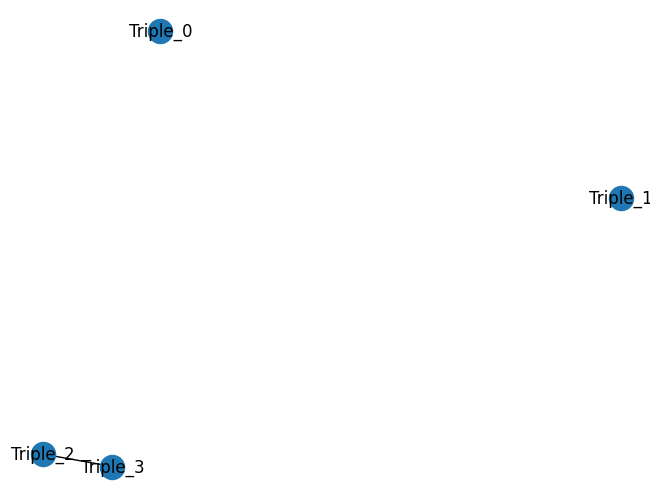

In [32]:
triples = triple_list
# Function to calculate cosine similarity
def calculate_similarity(str1, str2):
    vectorizer = CountVectorizer().fit([str1, str2])
    vec1 = vectorizer.transform([str1]).toarray()
    vec2 = vectorizer.transform([str2]).toarray()
    return cosine_similarity(vec1, vec2)[0][0]

# Add triple-nodes to the graph
G = nx.Graph()
triple_nodes = {}
for i, utterance in enumerate(triples):
    node_id = f"Triple_{i}"
    triple_nodes[node_id] = utterance
    G.add_node(node_id, triple=utterance)

# Connect triples based on contextual similarity
similarity_threshold = 0.5  # Define a threshold for similarity
for node_id1, triple1 in triple_nodes.items():
    for node_id2, triple2 in triple_nodes.items():
        if node_id1 != node_id2:
            # Perform Cartesian product comparison for all components
            for part1, part2 in itertools.product(triple1, triple2):
                if calculate_similarity(part1, part2) > similarity_threshold:
                    G.add_edge(node_id1, node_id2)
                    break  # Exit loop if any component pair is similar

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

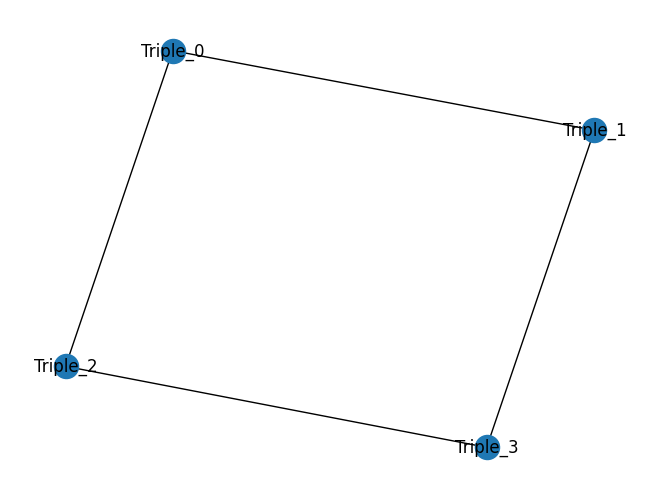

In [35]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import itertools

# Load the spaCy model
nlp = spacy.load("en_core_web_md")

# Function to calculate cosine similarity using spaCy
def calculate_similarity(str1, str2):
    doc1 = nlp(str1)
    doc2 = nlp(str2)
    return doc1.similarity(doc2)

# Your triples and graph initialization remains the same
triples = triple_list
G2 = nx.Graph()
triple_nodes = {}
for i, utterance in enumerate(triples):
    node_id = f"Triple_{i}"
    triple_nodes[node_id] = utterance
    G2.add_node(node_id, triple=utterance)

# Connect triples based on contextual similarity
similarity_threshold = 0.6
for node_id1, triple1 in triple_nodes.items():
    for node_id2, triple2 in triple_nodes.items():
        if node_id1 != node_id2:
            for part1, part2 in itertools.product(triple1, triple2):
                if calculate_similarity(part1, part2) > similarity_threshold:
                    G2.add_edge(node_id1, node_id2)
                    break

# Draw the graph
nx.draw(G2, with_labels=True)
plt.show()


In [37]:
# print the triple nodes
display(triple_nodes)

{'Triple_0': ('Engineering', 'be', 'a-difficult-field'),
 'Triple_1': ('Bob', 'love', 'his-vocation'),
 'Triple_2': ('Alice', 'work-as', 'engineer'),
 'Triple_3': ('Alice', 'hate', 'her-job')}

In [43]:
new_triples = extract_triples1()

# print the new triples
print(new_triples)

# remove the sentiment score from the triples
new_tripless = [triple[:-1] for triple in new_triples]

# add the new triples to the graph
for i, utterance in enumerate(new_tripless):
    node_id = f"Triple_{i}"
    triple_nodes[node_id] = utterance
    G2.add_node(node_id, triple=utterance)

# print the graph
nx.draw(G, with_labels=True)
plt.show()

TypeError: extract_triples1() missing 1 required positional argument: 'sentence'